## Trial time Dial in time First touch time

In [13]:
medianColor='cyan'

In [14]:
import os
from pathlib import Path
import sys
path = Path(os.getcwd())

abspath = str(path.absolute().parent.parent / 'bci_plot')
sys.path.append(abspath)

In [15]:
figure_creation_param = {
    'path':str(path.absolute().parent.parent / 'figs'),
}
for focus in ['Trial Time', 'Dial In Time', 'Time To First Touch']:
    (Path(figure_creation_param['path']) / focus).mkdir(parents=True, exist_ok=True)

In [16]:
from tools.data_util import load_data
from tools.iterate import get_copilot_session_names, get_copilot_session_by_ABA, get_trial_beginning_end, get_dial_in_time
from tools.plot import plotMeanStdBox
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import datetime
import yaml
import tqdm
from tools.ABA_bar_plot import plotABAbar
from tools.AB_box_plot import plotABboxfor4, plotABbox
import scipy


In [17]:
## all data in interest from exp tracker
copilotSessions = get_copilot_session_names()
copilotABASessions = get_copilot_session_by_ABA()

In [18]:
import datetime
import numpy as np
# keys
# ['timer_tick_time_ns', 'state_task', 'decoder_output', 'decoded_pos', 'target_pos', 'target_size', 'game_state', 'kf_state', 'kf_inf_state', 'kf_update_flag', 'allow_kf_adapt', 'allow_kf_sync', 'decoder_h', 'kf_R', 'kf_S', 'kf_T', 'kf_Tinv', 'kf_EBS', 'kf_C', 'kf_Q', 'kf_Qinv', 'kf_S_k', 'kf_K_k', 'kf_M1', 'kf_M2', 'kf_effective_vel', 'kf_ole_rlud', 'sessionLength', 'activeLength', 'cursorVel', 'ignoreWrongTarget', 'cursorMoveInCorretDirectionOnly', 'assistValue', 'assistMode', 'softmaxThres', 'holdTimeThres', 'kfCopilotAlpha', 'hitRate', 'missRate', 'timeoutRate', 'trialCount', 'render_angle', 'numCompletedBlocks', 'enableKfSyncInternal', 'eeg_step', 'gaze_step', 'time_ns', 'name', 'labels', 'dtypes']

for sessionName in copilotSessions:
    dataPath = Path('/data/raspy')
    taskData = load_data(dataPath / sessionName / 'task.bin')
    beginEnd = get_trial_beginning_end(taskData)
    trialResult = ''.join([chr(taskData['game_state'][e].item()) for b,e in beginEnd])
    print(sessionName, trialResult)
        


2024-02-14_H1_CL_CP_1 TTTTHHHHTHHHHHHHHHHHHHHHTHHH
2024-02-14_H1_CL_CP_2 TTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
2024-02-14_H1_CL_CP_3 TTTTTHHTHHHHHHHTTTHHHHHTTHHH
2024-02-14_H1_CL_CP_5 TTTTHTHHHHHHTHHHHHHHHHHTHHHT
2024-02-14_H1_CL_CP_6 TTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
2024-02-14_H1_CL_CP_7 TTTTTHHHHHTHHHHTHHHHHHHHHHHH
2024-02-15_H1_CL_5 TTTTHHHHHHHHHHHHHTHHTHHHHHHH
2024-02-15_H1_CL_6 TTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
2024-02-15_H1_CL_7 TTTTHHHHHHHHHHTTHHHHHHTHHHHH
2024-02-15_H1_CL_8 TTTTHTHTTTHTTHTTTHTT
2024-02-15_H1_CL_9 TTTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTHHHH
2024-02-15_H1_CL_10 TTTTTTHTHTTTHTTTTTTT
2024-02-20_H1_CL_5 TTTTHHHHHHHHHHHHHHTTHHHHTHHH
2024-02-20_H1_CL_6 TTTTHHHHHHHHHHHHHHHHHHHHHHHHHTHHHHHH
2024-02-20_H1_CL_7 TTTTHHHHHHTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
2024-02-20_H1_CL_8 TTTTTHHHHHHHHTTHHHHTHHHHHHHH
2024-02-16_H2_CL_2 TTTTTHTTHHHTTHTHHHHT
2024-02-16_H2_CL_3 TTTTHHHHHHHHHHTHTTHHTTHHHHHH
2024-02-16_H2_CL_4 TTTTHHHTHT

### Total Trial Time, Dial in Time, Time to First Touch (First Touch)

### unity line graph for Total Trial Time, Dial in Time, Time to First Touch (First Touch)

13it [00:01,  9.96it/s]


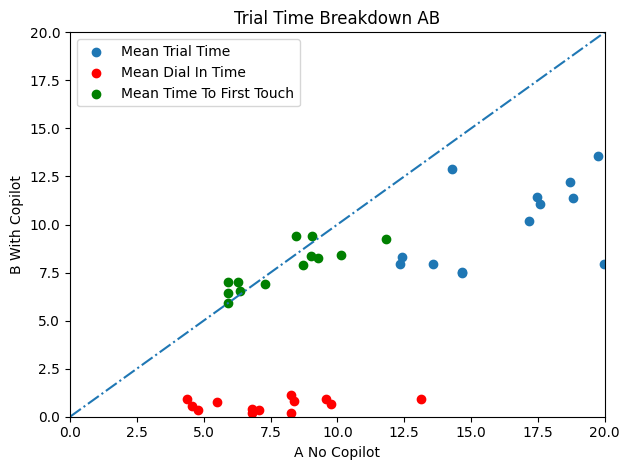

In [19]:
# get time to touch
copilotABASessions = get_copilot_session_by_ABA()

totalTrialTimeAllA = []
totalTrialTimeAllB = []
dialInTimeAllA = []
dialInTimeAllB = []
timeToAcquireAllA = []
timeToAcquireAllB = []

totalTrialTimeMeanA = []
totalTrialTimeMeanB = []
dialInTimeMeanA = []
dialInTimeMeanB = []
timeToAcquireMeanA = []
timeToAcquireMeanB = []

for i, ABAsession in tqdm.tqdm(enumerate(copilotABASessions)):

    totalTrialTimeA = []
    timeToAcquireA = []
    dialInTimeA = []
    totalTrialTimeB = []
    timeToAcquireB = []
    dialInTimeB = []

    for sessionName, label in zip(ABAsession,('A1','B1','A2')):
    # for sessionName, label in zip(ABAsession[1:],(f'{i}B',f'{i}A')):    
        dataPath = Path('/data/raspy')
        taskData = load_data(dataPath / sessionName / 'task.bin')
        timeToAcquire, dialInTime, totalTrialTime = get_dial_in_time(taskData)

        # remove None
        dialInTime = [item for item in dialInTime if item is not None]
        timeToAcquire = [item for item in timeToAcquire if item is not None]

        # add all (but they have different number so truncate it)
        if label == 'A1': totalTrialTimeA = totalTrialTime
        if label == 'B1': totalTrialTimeB = totalTrialTime
        if label == 'A1': dialInTimeA = dialInTime
        if label == 'B1': dialInTimeB = dialInTime
        if label == 'A1': timeToAcquireA = timeToAcquire
        if label == 'B1': timeToAcquireB = timeToAcquire

        # convert to numpy
        totalTrialTime = np.array(totalTrialTime)
        dialInTime = np.array(dialInTime)
        timeToAcquire = np.array(timeToAcquire)

        # find its mean
        totalTrialTimeMean = totalTrialTime.mean()
        dialInTimeMean = dialInTime.mean()
        timeToAcquireMean = timeToAcquire.mean()

        # add mean
        if label == 'A1': totalTrialTimeMeanA.append(totalTrialTimeMean)
        if label == 'B1': totalTrialTimeMeanB.append(totalTrialTimeMean)
        if label == 'A1': dialInTimeMeanA.append(dialInTimeMean)
        if label == 'B1': dialInTimeMeanB.append(dialInTimeMean)
        if label == 'A1': timeToAcquireMeanA.append(timeToAcquireMean)
        if label == 'B1': timeToAcquireMeanB.append(timeToAcquireMean)
    
    totalTrialTimeAllA += totalTrialTimeA[-min(len(totalTrialTimeA),len(totalTrialTimeB)):]
    totalTrialTimeAllB += totalTrialTimeB[-min(len(totalTrialTimeA),len(totalTrialTimeB)):]
    dialInTimeAllA += dialInTimeA[-min(len(dialInTimeA),len(dialInTimeB)):]
    dialInTimeAllB += dialInTimeB[-min(len(dialInTimeA),len(dialInTimeB)):]
    timeToAcquireAllA += timeToAcquireA[-min(len(timeToAcquireA),len(timeToAcquireB)):]
    timeToAcquireAllB += timeToAcquireB[-min(len(timeToAcquireA),len(timeToAcquireB)):]

plt.scatter(totalTrialTimeMeanA, totalTrialTimeMeanB,label='Mean Trial Time')
plt.scatter(dialInTimeMeanA, dialInTimeMeanB,color='r',label='Mean Dial In Time')
plt.scatter(timeToAcquireMeanA, timeToAcquireMeanB,color='g',label='Mean Time To First Touch')
plt.plot(np.linspace(0,22,100),np.linspace(0,22,100),'-.')
plt.title('Trial Time Breakdown AB')
plt.legend()
plt.xlabel('A No Copilot')
plt.ylabel('B With Copilot')
plt.xlim(0,20)
plt.ylim(0,20)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
plt.savefig(f'{figure_creation_param["path"]}/Trial Time/Trial Time Breakdown AB unity line.pdf')
plt.show()

# plt.scatter(totalTrialTimeMeanA, totalTrialTimeMeanB,label='Mean Trial Time')
# plt.plot(np.linspace(0,22,100),np.linspace(0,22,100),'-.')
# plt.title('Trial Time AB')
# plt.xlabel('A No Copilot')
# plt.ylabel('B With Copilot')
# plt.xlim(0,20)
# plt.ylim(0,20)
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['pdf.fonttype'] = 42
# plt.tight_layout()
# plt.savefig(f'{figure_creation_param["path"]}/Trial Time/Trial Time AB unity line.pdf')
# plt.show()


# plt.scatter(dialInTimeMeanA, dialInTimeMeanB,color='r',label='Mean Dial In Time')
# plt.plot(np.linspace(0,22,100),np.linspace(0,22,100),'-.')
# plt.title('Dial In Time AB')
# plt.xlabel('A No Copilot')
# plt.ylabel('B With Copilot')
# plt.xlim(0,20)
# plt.ylim(0,20)
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['pdf.fonttype'] = 42
# plt.tight_layout()
# plt.savefig(f'{figure_creation_param["path"]}/Dial In Time/Dial In Time AB unity line.pdf')
# plt.show()


# plt.scatter(timeToAcquireMeanA, timeToAcquireMeanB,color='g',label='Mean Time To First Touch')
# plt.plot(np.linspace(0,22,100),np.linspace(0,22,100),'-.')
# plt.title('Time To First Touch AB')
# plt.xlabel('A No Copilot')
# plt.ylabel('B With Copilot')
# plt.xlim(0,20)
# plt.ylim(0,20)
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['pdf.fonttype'] = 42
# plt.tight_layout()
# plt.savefig(f'{figure_creation_param["path"]}/Time To First Touch/Time To First Touch AB unity line.pdf')
# plt.show()


    

## nicer format with 4 ppl

In [20]:
# get time to touch
copilotABASessions = get_copilot_session_by_ABA()

Collection = {}
subjects = ['H1','H2','H4','S2']
ABAlabels = ['A1','B1','A2']
metrics = ['Trial Time', 'Dial In Time', 'Time To First Touch']
for s in subjects:
    Collection[s] = {}
    for label in ABAlabels:
        Collection[s][label] = {metric:[] for metric in metrics}


for i, ABAsession in tqdm.tqdm(enumerate(copilotABASessions)):
    for sessionName, label in zip(ABAsession, ABAlabels):
    # for sessionName, label in zip(ABAsession[1:],(f'{i}B',f'{i}A')):    
        dataPath = Path('/data/raspy')
        taskData = load_data(dataPath / sessionName / 'task.bin')
        timeToAcquire, dialInTime, totalTrialTime = get_dial_in_time(taskData)

        # change to numpy format
        totalTrialTime = totalTrialTime
        dialInTime = [item for item in dialInTime if item is not None]
        timeToAcquire = [item for item in timeToAcquire if item is not None]

        # add it to correct bin
        for subject in subjects:
            if subject in sessionName:
                Collection[subject][label]['Trial Time'] += totalTrialTime
                Collection[subject][label]['Dial In Time'] += dialInTime
                Collection[subject][label]['Time To First Touch'] += timeToAcquire
                break

0it [00:00, ?it/s]

13it [00:01,  9.95it/s]


In [21]:
# get hit collection by box for AB only with no duplication
CollectionNoDup = {}
subjectsWithHealthySCI = ['H1','H2','H4','S2', 'Healthy', 'SCI'] # just for this no dup
ABAlabels = ['A','B']
metrics = ['Trial Time', 'Dial In Time', 'Time To First Touch']
for s in subjectsWithHealthySCI:
    CollectionNoDup[s] = {}
    for label in ABAlabels:
        CollectionNoDup[s][label] = {metric:[] for metric in metrics}

for sessionName, label in tqdm.tqdm(get_copilot_session_names(label=True)):
    # getSessionName, subject name, label
    subjectName = sessionName.split('_')[1]

    dataPath = Path('/data/raspy')
    taskData = load_data(dataPath / sessionName / 'task.bin')
    timeToAcquire, dialInTime, totalTrialTime = get_dial_in_time(taskData)

    # change to numpy format
    totalTrialTime = totalTrialTime
    dialInTime = [item for item in dialInTime if item is not None]
    timeToAcquire = [item for item in timeToAcquire if item is not None]

    # add it to correct bin
    CollectionNoDup[subjectName][label]['Trial Time'] += totalTrialTime
    CollectionNoDup[subjectName][label]['Dial In Time'] += dialInTime
    CollectionNoDup[subjectName][label]['Time To First Touch'] += timeToAcquire

# Healthy & SCI
for label in ABAlabels:
    for s in subjectsWithHealthySCI:
        if 'H' in s and len(s) == 2:
            CollectionNoDup['Healthy'][label]['Trial Time'] += CollectionNoDup[s][label]['Trial Time']
            CollectionNoDup['Healthy'][label]['Dial In Time'] += CollectionNoDup[s][label]['Dial In Time']
            CollectionNoDup['Healthy'][label]['Time To First Touch'] += CollectionNoDup[s][label]['Time To First Touch']

        if 'S' in s and len(s) == 2:
            CollectionNoDup['SCI'][label]['Trial Time'] += CollectionNoDup[s][label]['Trial Time']
            CollectionNoDup['SCI'][label]['Dial In Time'] += CollectionNoDup[s][label]['Dial In Time']
            CollectionNoDup['SCI'][label]['Time To First Touch'] += CollectionNoDup[s][label]['Time To First Touch']
        


  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:01<00:00, 30.19it/s]


### box plot AB

Trial Time H1 A median 13.527316378
Trial Time H1 B median 6.8781920825
Trial Time H2 A median 19.124761927
Trial Time H2 B median 9.674553162
Trial Time H4 A median 17.124795108
Trial Time H4 B median 8.8767164935
Trial Time S2 A median 23.94943225
Trial Time S2 B median 10.8500322155
Trial Time Healthy A median 15.478878226500001
Trial Time Healthy B median 7.449966585
Trial Time SCI A median 23.94943225
Trial Time SCI B median 10.8500322155
Dial In Time H1 A median 5.325234581
Dial In Time H1 B median 0.044659318
Dial In Time H2 A median 6.200600879
Dial In Time H2 B median 0.04949449100000003
Dial In Time H4 A median 3.500272624
Dial In Time H4 B median 0.04740259300000005
Dial In Time S2 A median 4.14974889
Dial In Time S2 B median 0.04919926899999999
Dial In Time Healthy A median 4.8995225895
Dial In Time Healthy B median 0.047115772
Dial In Time SCI A median 4.14974889
Dial In Time SCI B median 0.04919926899999999
Time To First Touch H1 A median 5.774379945
Time To First Touch H

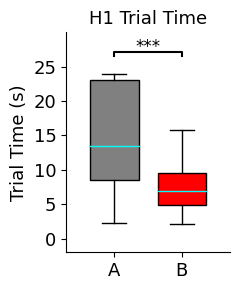

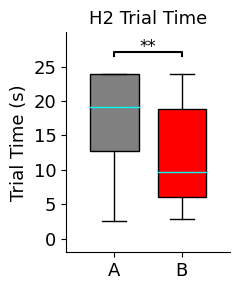

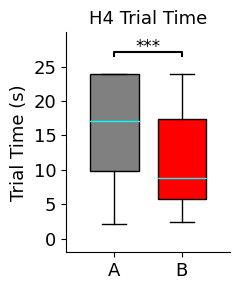

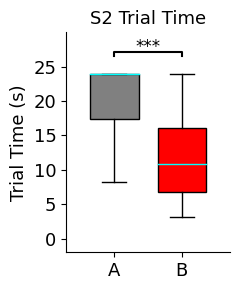

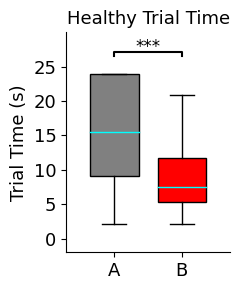

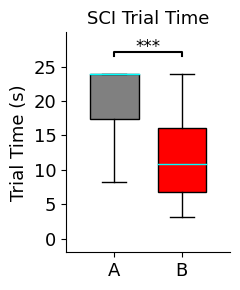

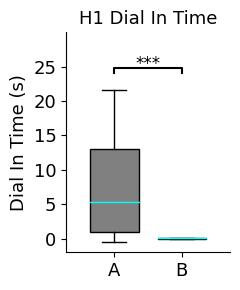

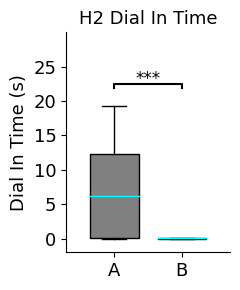

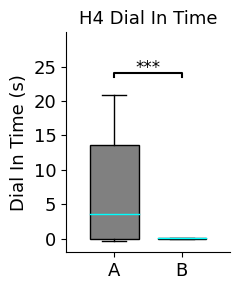

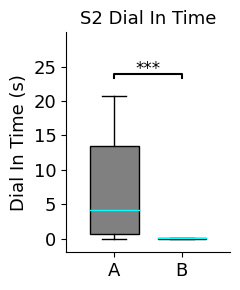

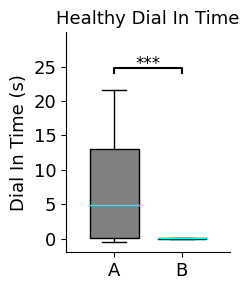

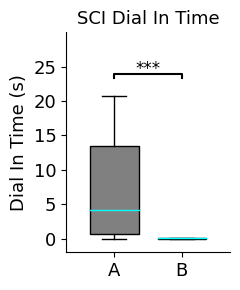

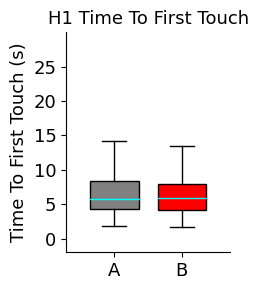

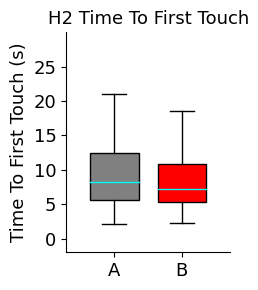

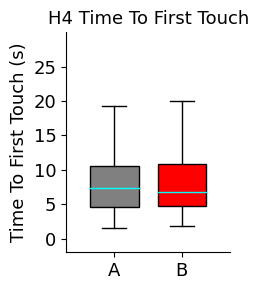

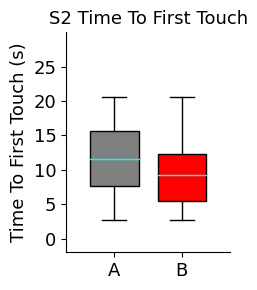

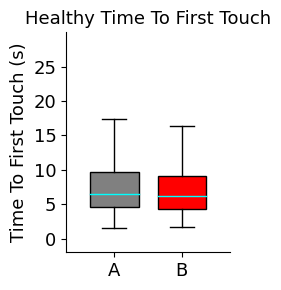

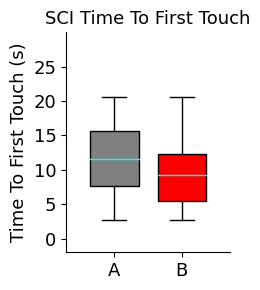

In [22]:
ylim = (-2, 30)
useStar = True
useP = False
for focus in ['Trial Time', 'Dial In Time', 'Time To First Touch']:

    for subject in subjectsWithHealthySCI:
        labels = ['A', 'B']
        colors = ['grey', 'red']
        CollectionA = CollectionNoDup[subject]['A'][focus]
        CollectionB = CollectionNoDup[subject]['B'][focus]


        print(focus, subject, 'A median', np.median(CollectionA))
        print(focus, subject, 'B median', np.median(CollectionB))

        plotABbox(CollectionA, CollectionB, 
                title=f'{subject} {focus}',
                ylabel=f'{focus} (s)',
                ylim=ylim,
                manual_y_ticks=(0,5,10,15,20,25),
                medianColor=medianColor,
                #   useStar=True,
                savePath=f'{figure_creation_param["path"]}/{focus}/{focus} AB box stars {subject}.pdf',
                useStar=True,
                useLegends=False,
                others = {
                    'figsize':(2.5, 3),
                    'barpos':[0,0.7],
                    'ylabelFontSize':13,
                    'titleFontSize': 13,
                })

### box plot AB (All 4 in same plot)

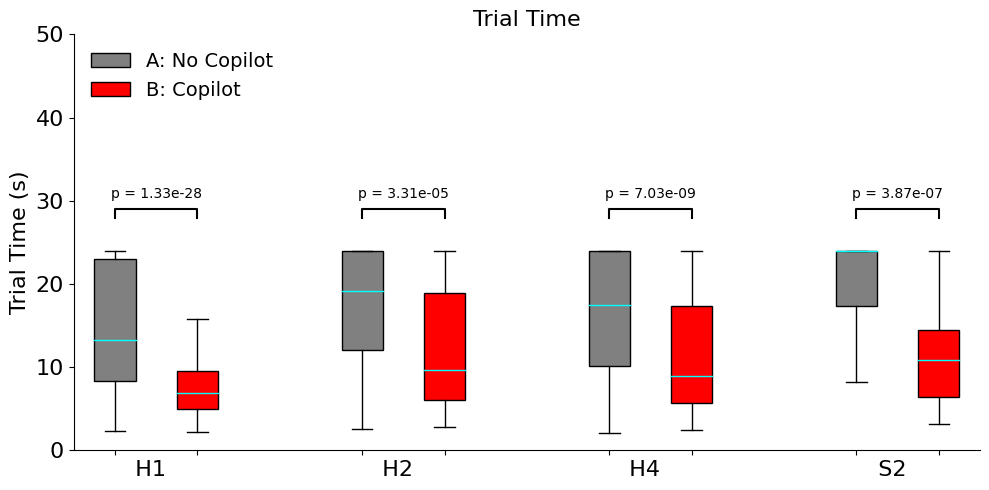

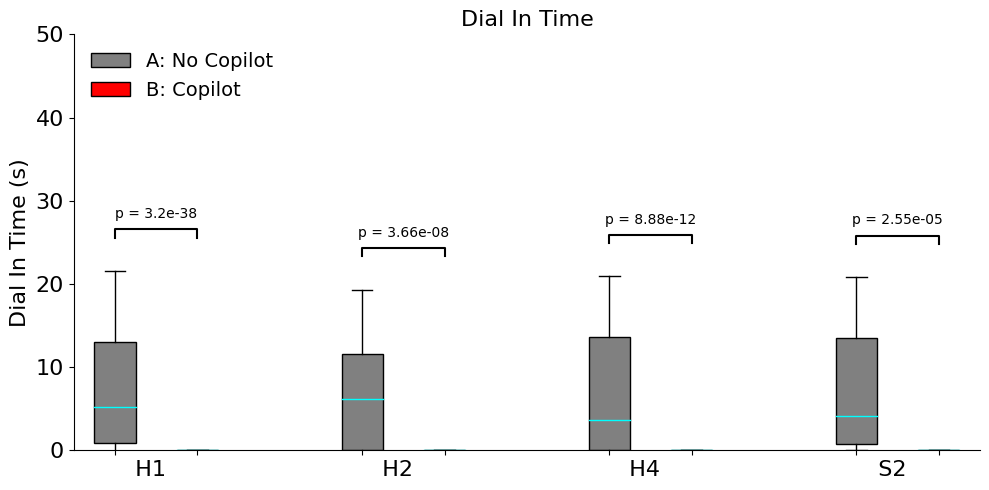

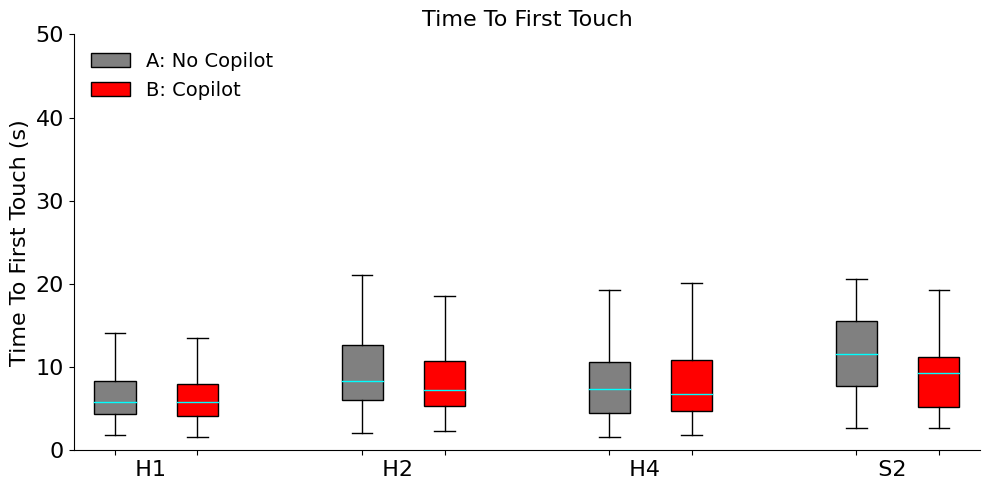

In [23]:
ylim = (0, 50)
useStar = False
useP = True

for focus in ['Trial Time', 'Dial In Time', 'Time To First Touch']:

    CollectionA = []
    CollectionB = []
    for subject in subjects:
        labels = ['A', 'B']
        colors = ['grey', 'red']
        CollectionA += [np.concatenate([Collection[subject]['A1'][focus], Collection[subject]['A2'][focus]])]
        CollectionB += [Collection[subject]['B1'][focus]]

    plotABboxfor4(CollectionA, CollectionB, 
              title=f'{focus}',
              ylabel=f'{focus} (s)',
              ylim=ylim,
              medianColor=medianColor,
              #savePath=f'{figure_creation_param["path"]}/{focus}/{focus} AB box pvalue all subjects (dup).pdf',
              useP=True)

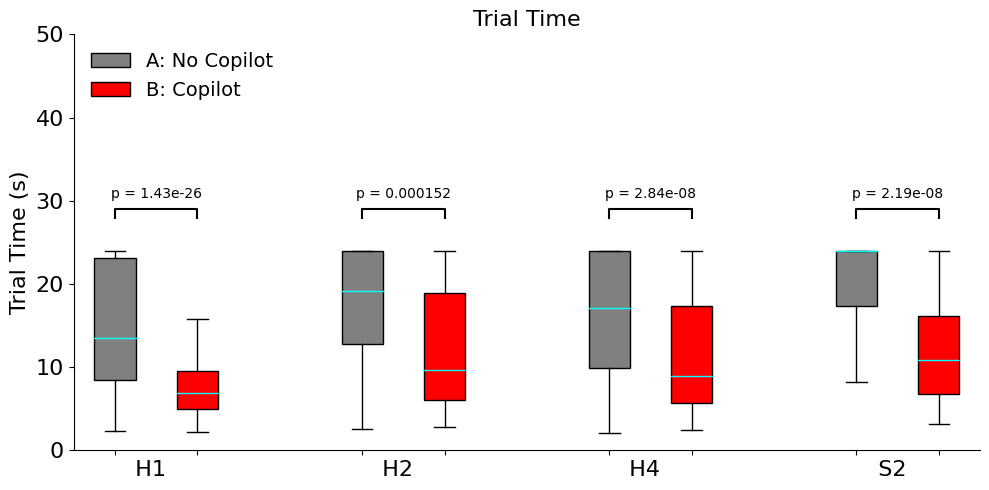

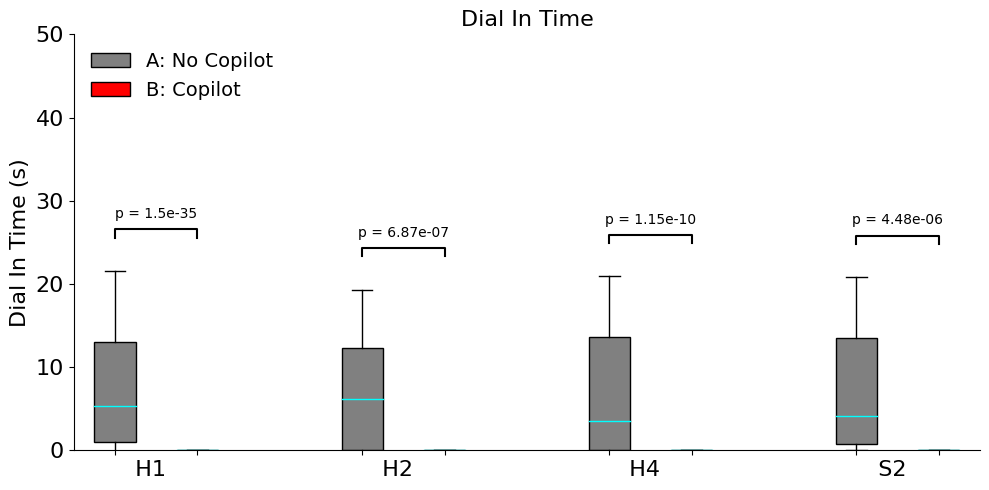

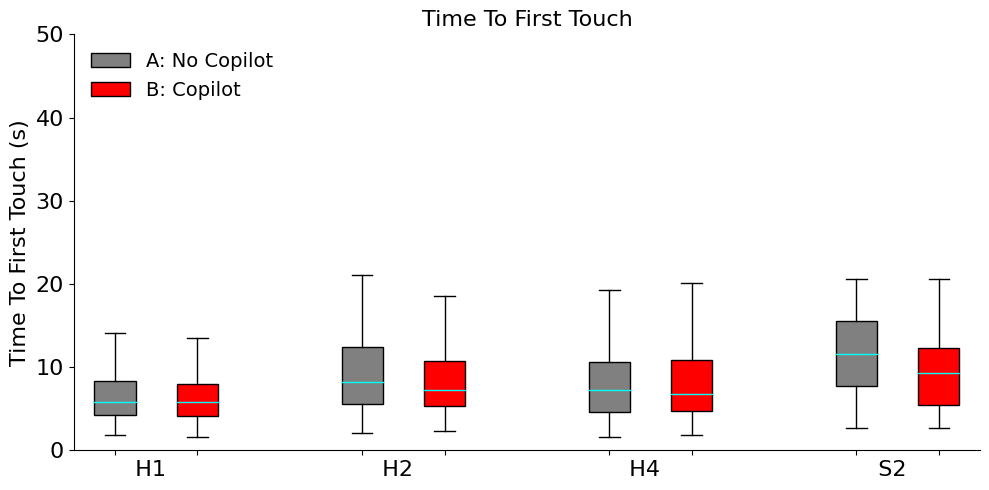

In [24]:
ylim = (0, 50)
useStar = False
useP = True

for focus in ['Trial Time', 'Dial In Time', 'Time To First Touch']:

    CollectionA = []
    CollectionB = []
    for subject in subjects:
        labels = ['A', 'B']
        colors = ['grey', 'red']
        CollectionA += [CollectionNoDup[subject]['A'][focus]]
        CollectionB += [CollectionNoDup[subject]['B'][focus]]

    plotABboxfor4(CollectionA, CollectionB, 
              title=f'{focus}',
              ylabel=f'{focus} (s)',
              ylim=ylim,
              medianColor=medianColor,
              #savePath=f'{figure_creation_param["path"]}/{focus}/{focus} AB box pvalue all subjects.pdf',
              useP=True)